In [1]:
!pip install imgkit --quiet # For rendering images from HTML tables

In [2]:
!sudo apt-get install wkhtmltopdf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libqt5positioning5 libqt5qml5 libqt5quick5 libqt5sensors5 libqt5svg5
  libqt5webchannel5 libqt5webkit5 xnest
Suggested packages:
  qt5-qmltooling-plugins
The following NEW packages will be installed:
  libqt5positioning5 libqt5qml5 libqt5quick5 libqt5sensors5 libqt5svg5
  libqt5webchannel5 libqt5webkit5 wkhtmltopdf xnest
0 upgraded, 9 newly installed, 0 to remove and 23 not upgraded.
Need to get 16.2 MB of archives.
After this operation, 66.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libqt5svg5 amd64 5.12.8-0ubuntu1 [131 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libqt5positioning5 amd64 5.12.8+dfsg-0ubuntu1 [197 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libqt5qml5 amd64 5.12.8-0ubuntu1 [1,438 kB]
Get:4 http://archive.ubuntu.com/ubuntu 

In [3]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib.lines import Line2D  
import imgkit
from PIL import Image

---
## **Loading data with tree structures and Pareto fronts**

In [4]:
DATA_URL = "https://drive.google.com/uc?export=download&id=1JizzRHBbtD0s4YVoJA6CVLNNq6YNuXkm" 
# https://drive.google.com/file/d/1JizzRHBbtD0s4YVoJA6CVLNNq6YNuXkm/view?usp=sharing
DATA_DATAPATH = 'data.zip'

gdown.download(DATA_URL, DATA_DATAPATH, quiet=True)

'data.zip'

In [5]:
DATA_PF_URL = "https://drive.google.com/uc?export=download&id=1DP2rtEZbsg1XBxOlqNVSEEN6iM2ZSPyo" 
# https://drive.google.com/file/d/1DP2rtEZbsg1XBxOlqNVSEEN6iM2ZSPyo/view?usp=sharing
DATA_PF_DATAPATH = 'data-pf.zip'

gdown.download(DATA_PF_URL, DATA_PF_DATAPATH, quiet=True)

'data-pf.zip'

In [6]:
REFERENCE_PARETOS_URL = "https://drive.google.com/uc?export=download&id=1lyeAB1Zc6sgTeKl7xmvAa57uYIbFuVjZ" 
# https://drive.google.com/file/d/1lyeAB1Zc6sgTeKl7xmvAa57uYIbFuVjZ/view?usp=sharing
REFERENCE_PARETOS_DATAPATH = 'reference-paretos.zip'

gdown.download(REFERENCE_PARETOS_URL, REFERENCE_PARETOS_DATAPATH, quiet=True)

'reference-paretos.zip'

In [7]:
%%capture
!mkdir files # Transfer all the datasets to specific folders
!unzip -o $DATA_PF_DATAPATH -d files/datapfs
!unzip -o $DATA_DATAPATH -d files/data
!unzip -o $REFERENCE_PARETOS_DATAPATH -d files/rfs

In [8]:
#!rm -r 'files' 

## **Tree Parsing and Visualization**

In [9]:
# This is for DOT files containing prefix trees
def parse_trie(filename):
  trie = nx.drawing.nx_pydot.read_dot(filename)
  trie.remove_node("\\n") # This is an error in the parsing
  for n, data in trie.nodes(data=True):
    data['fillcolor'] = data['fillcolor'].strip("\"")
    data['label'] = data['label'].strip("\"")
    data['width'] = float(data['width'].strip("\""))
    data['ninstances'] = int(data['ninstances'].strip("\""))
  
  for n, m, data in trie.edges(data=True):
    data['width'] = float(data['width'].strip("\""))

  print(trie.number_of_nodes(), "nodes")
  print(trie.number_of_edges(), "edges")
  return trie

In [10]:
def find_node(trie, path, nlabel='source'):
  root = trie.nodes['0']
  #print("tree root:", root)
  n = '0'
  for v in path:
    matching = False
    for s in trie.successors(n):
      #print(tries.nodes[s])
      if trie.nodes[s][nlabel] == v:
        matching = True
        #print(v, "...got a match=", s)
        n = s
        break

    if not matching:
      #print("matching aborted for", v)
      n = None
      break
  
  return n

def get_sequence_as_path(trie, sequence, root='0'):
  node = find_node(trie, sequence)
  path = nx.shortest_path(trie, source=root, target=node)
  return path

def draw_prefix_tree(trie, size=(15,15), layout='graphviz', prog='twopi', title=None, 
                     nlabel='source', paths=None, ninstances=True, margin=0.0, color='red'):

  final_nodes = []
  if ninstances:
    for n in trie.nodes():
      if trie.out_degree(n) == 0:
        final_nodes.append(n)

  # Get properties for the nodes from their attributes
  labels = nx.get_node_attributes(trie, nlabel) #nx.get_node_attributes(trie, 'refaction')
  line_colors = nx.get_node_attributes(trie, 'color').values()
  node_colors =  nx.get_node_attributes(trie, 'fillcolor') # ['#FFFFFF']*trie.number_of_nodes()
  linewidths =  list(nx.get_node_attributes(trie, 'width').values()) #[1.5]*trie.number_of_nodes() #nx.get_node_attributes(trie, 'width').values() 
  sizes_dict = nx.get_node_attributes(trie, 'ninstances')
  sizes = [500+50*(s-1) if (k in final_nodes) else 500 for (k,s) in sizes_dict.items()]

  #edge_linewidths = list(nx.get_edge_attributes(trie, 'width').values())
  edge_linewidths = 1.0
  edge_colors = 'black'
  edge_list = None
  if paths is not None:
    flat_list = set([item for sublist in paths for item in sublist])
    for n in flat_list:
      node_colors[n] = color
    edge_linewidths = list()
    edge_colors = list()
    edge_list = list()
    for n, m in trie.edges():
      edge_list.append((n,m))
      if (n in flat_list) and (m in flat_list):
        edge_linewidths.append(2.0)
        edge_colors.append(color)
      else:
        edge_linewidths.append(1.0)
        edge_colors.append('black')

  fig = plt.figure(figsize=size) 
  fig.suptitle(title, fontsize=20)

  if layout == 'graphviz':
    pos = graphviz_layout(trie, prog=prog, root='0')
    nodes = nx.draw_networkx_nodes(trie, pos, node_color=node_colors.values(), linewidths=linewidths, node_size=sizes, )
    nodes.set_edgecolors(line_colors)
    labels = nx.draw_networkx_labels(trie, pos, labels=labels)
    edges = nx.draw_networkx_edges(trie, pos, edgelist=edge_list, width=edge_linewidths, edge_color=edge_colors)
  else:
    nodes = nx.draw_networkx_nodes(trie, pos=nx.spring_layout(trie), node_color='cyan', node_size=sizes)
    labels = nx.draw_networkx_labels(trie, pos=nx.spring_layout(trie))
    edges = nx.draw_networkx_edges(trie, pos=nx.spring_layout(trie))

 #'a': 'Move_Component_New_Node',
 #'b': 'Move_Operation_Component',
 #'c': 'Move_Operation_New_Component_New_Node',
 #'d': 'UMLCloneNode'}
  if paths is not None:
    legend_elements = [
      Line2D([0],[0], marker='o', markeredgecolor='black', markersize=15, color='w', label='a: ReDe'), #label='a: Move_Component_New_Node'),
      Line2D([0],[0], marker='o', markeredgecolor='black', markersize=15, color='w', label='b: MO2C'), #label='b: Move_Operation_Component'),
      Line2D([0],[0], marker='o', markeredgecolor='black', markersize=15, color='w', label='c: MO2N'), #label='c: Move_Operation_New_Component_New_Node'),
      Line2D([0],[0], marker='o', markeredgecolor='black', markersize=15, color='w', label='d: Clon') #label='d: UMLCloneNode'),    
    ]
    plt.legend(handles=legend_elements, loc='upper right', prop={'size': 18}, bbox_to_anchor=(1.0, 1.0))
  
  plt.margins(margin)
  fig.tight_layout() 
  plt.grid(visible=False)
  plt.box(False)
  
  plt.show()

156 nodes
155 edges


<ipython-input-10-d434091fb1e5>:68: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(trie, prog=prog, root='0')


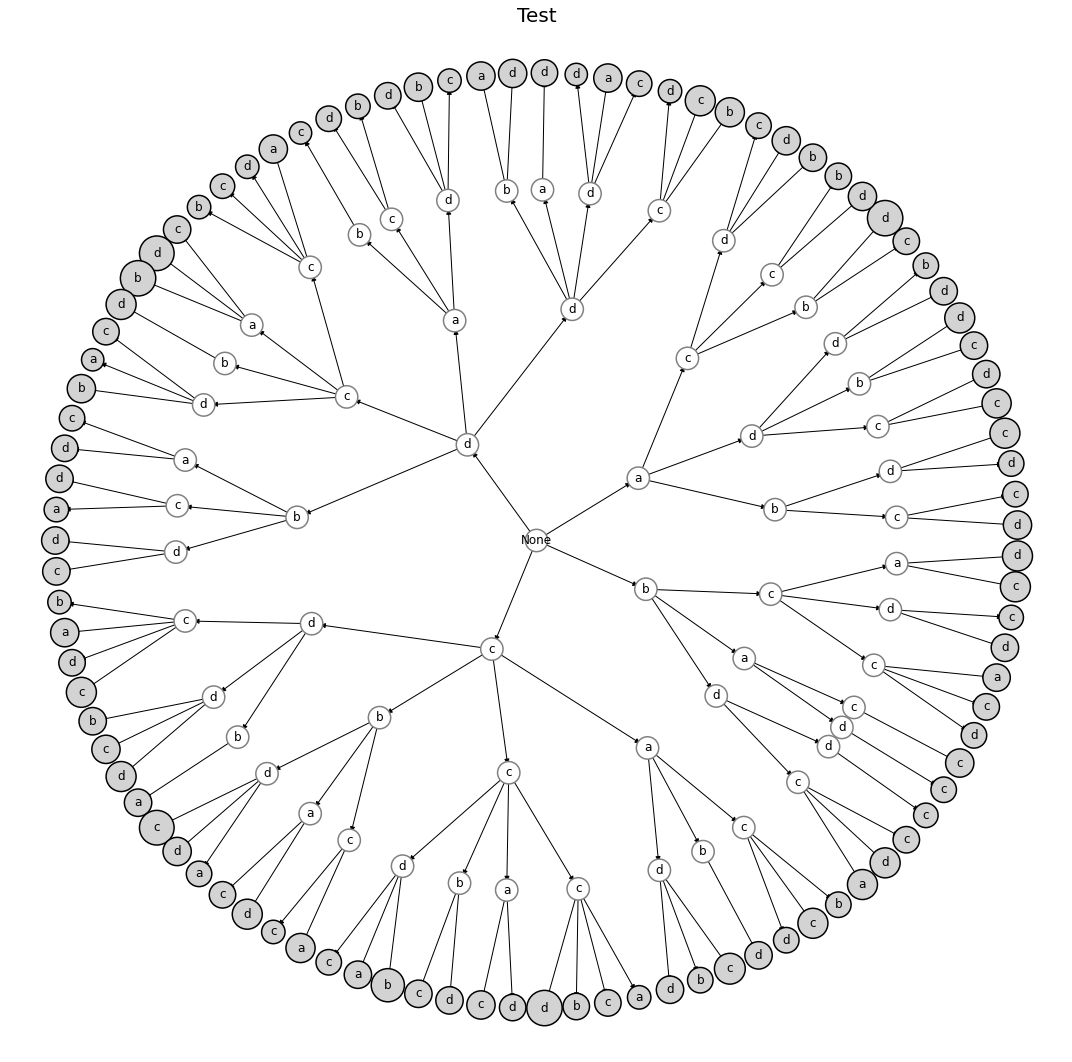

In [11]:
# Loading a particular tree in DOT format
it9_trie = parse_trie('/content/files/datapfs/it9_trie_pf-trainticket-nsgaii.dot')
draw_prefix_tree(it9_trie, title='Test', nlabel='source')

In [12]:
# Functions for comparing tree paths
def sequence_match(s1, s2, trie1, trie2):
  seq1 = ''.join([trie1.nodes[n]['source'] for n in s1])[len('None'):]
  seq2 = ''.join([trie2.nodes[n]['source'] for n in s2])[len('None'):]
  #print(seq1, "=?=", seq2)
  return (seq1 == seq2), seq1, seq2

def compare_tries(trie1, trie2, size=(15,12), title1='', title2='', margin=0.05, color='orange'):

  final_nodes1 = [n for n in trie1.nodes() if trie1.out_degree(n) == 0]
  final_nodes2 = [n for n in trie2.nodes() if trie2.out_degree(n) == 0]

  sequences1 = [tuple(nx.shortest_path(trie1,'0', n)) for n in final_nodes1]
  print(len(sequences1), "sequences")
  #print(sequences1)
  encoding = dict()
  for x in sequences1:
    encoding[trie1.nodes[x[0]]['source']] = trie1.nodes[x[0]]['refaction']
    encoding[trie1.nodes[x[1]]['source']] = trie1.nodes[x[1]]['refaction']
    encoding[trie1.nodes[x[2]]['source']] = trie1.nodes[x[2]]['refaction']
    encoding[trie1.nodes[x[3]]['source']] = trie1.nodes[x[3]]['refaction']
  #print(encoding)

  sequences2 = [tuple(nx.shortest_path(trie2,'0', n)) for n in final_nodes2]
  print(len(sequences2), "sequences")
  #print(sequences2)
  #encoding = dict()
  for x in sequences2:
    encoding[trie2.nodes[x[0]]['source']] = trie2.nodes[x[0]]['refaction']
    encoding[trie2.nodes[x[1]]['source']] = trie2.nodes[x[1]]['refaction']
    encoding[trie2.nodes[x[2]]['source']] = trie2.nodes[x[2]]['refaction']
    encoding[trie2.nodes[x[3]]['source']] = trie2.nodes[x[3]]['refaction']
  print("Encoding:", encoding)

  intersection1 = []
  intersection2 = []
  seq_matching = []
  for s1 in sequences1:
    for s2 in sequences2:
      matching, seq1, seq2 = sequence_match(s1, s2, trie1, trie2)
      if matching:
        #print("matching:", seq1, seq2)
        seq_matching.append(seq1)
        intersection1.append(s1)
        intersection2.append(s2)

  print("intersection:", len(seq_matching), seq_matching)

  draw_prefix_tree(trie1, paths=intersection1, nlabel='source', ninstances=False, size=size, title=title1, margin=margin, color=color)
  draw_prefix_tree(trie2, paths=intersection2, nlabel='source', ninstances=False, size=size, title=title2, margin=margin, color=color)

  return encoding

135 nodes
134 edges
69 nodes
68 edges
78 sequences
34 sequences
Encoding: {'None': 'None', 'c': 'Move_Operation_New_Component_New_Node', 'd': 'UMLCloneNode', 'a': 'Move_Component_New_Node', 'b': 'Move_Operation_Component'}
intersection: 9 ['cbcc', 'cbac', 'ccbc', 'cccb', 'ccca', 'ccab', 'abcc', 'acbc', 'bccc']


<ipython-input-10-d434091fb1e5>:68: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(trie, prog=prog, root='0')


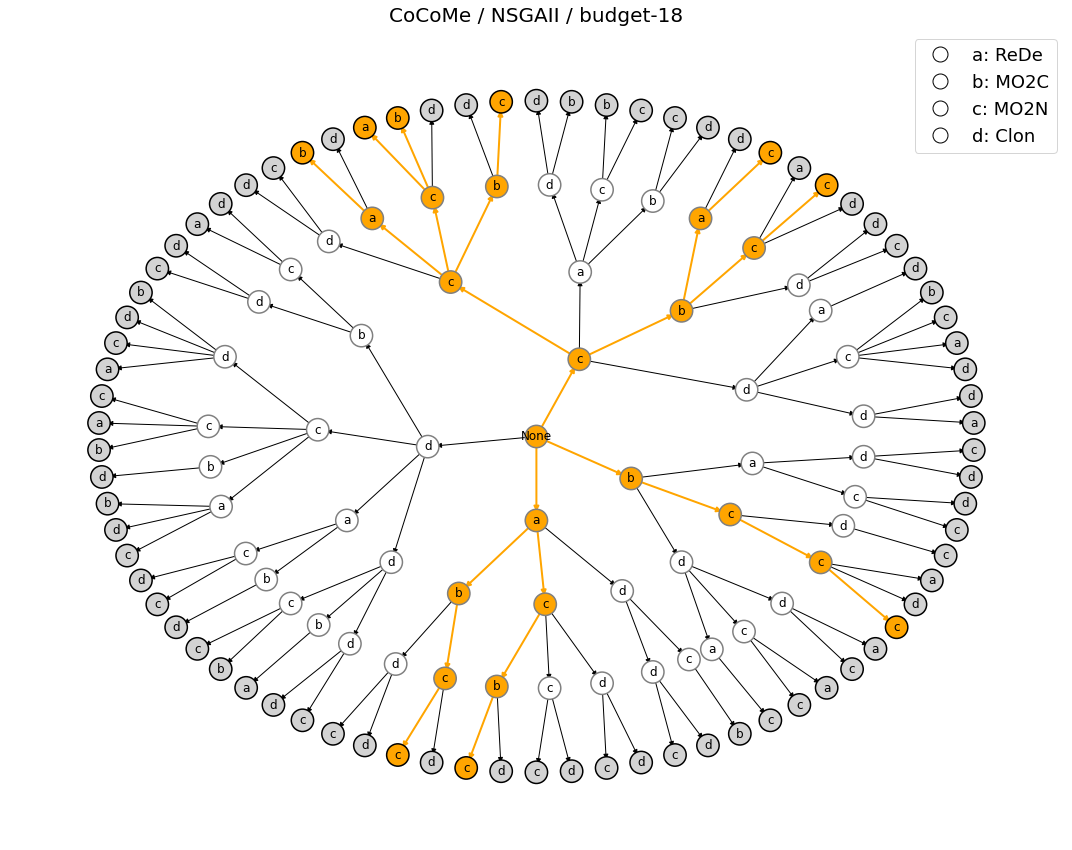

<ipython-input-10-d434091fb1e5>:68: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(trie, prog=prog, root='0')


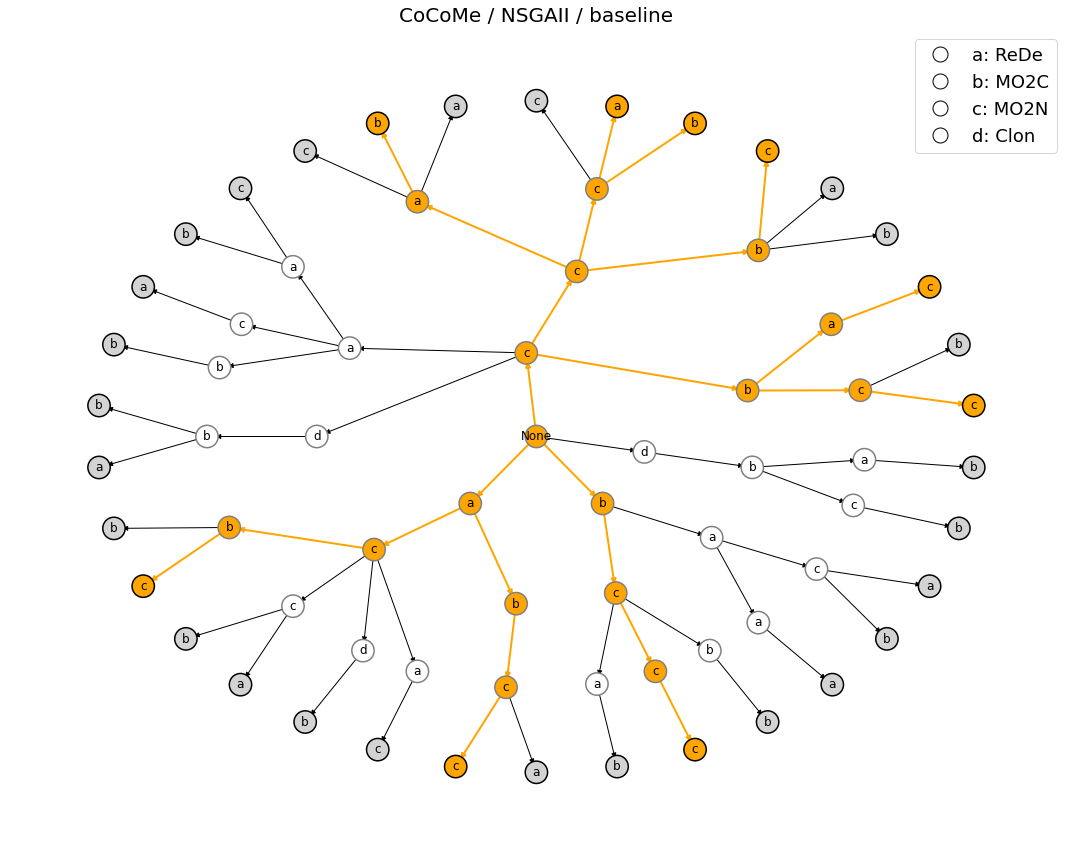

{'None': 'None',
 'c': 'Move_Operation_New_Component_New_Node',
 'd': 'UMLCloneNode',
 'a': 'Move_Component_New_Node',
 'b': 'Move_Operation_Component'}

In [13]:
# Code that loads 2 trees (in DOT format) and then compares them - COCOME
it18_trie = parse_trie('/content/files/datapfs/it18_trie_pf-cocome-nsgaii.dot')
ref100_trie = parse_trie('/content/files/datapfs/ref100_trie_pf-cocome-nsgaii.dot')

compare_tries(it18_trie, ref100_trie, title1='CoCoMe / NSGAII / budget-18', title2='CoCoMe / NSGAII / baseline')

144 nodes
143 edges
52 nodes
51 edges
84 sequences
25 sequences
Encoding: {'None': 'None', 'd': 'UMLCloneNode', 'c': 'Move_Operation_New_Component_New_Node', 'a': 'Move_Component_New_Node', 'b': 'Move_Operation_Component'}
intersection: 16 ['dccc', 'dccb', 'bccc', 'ccdc', 'ccdb', 'ccbd', 'ccbc', 'cccd', 'ccca', 'cccb', 'cccc', 'ccac', 'cbcc', 'cdcc', 'cdcb', 'acbc']


<ipython-input-10-d434091fb1e5>:68: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(trie, prog=prog, root='0')


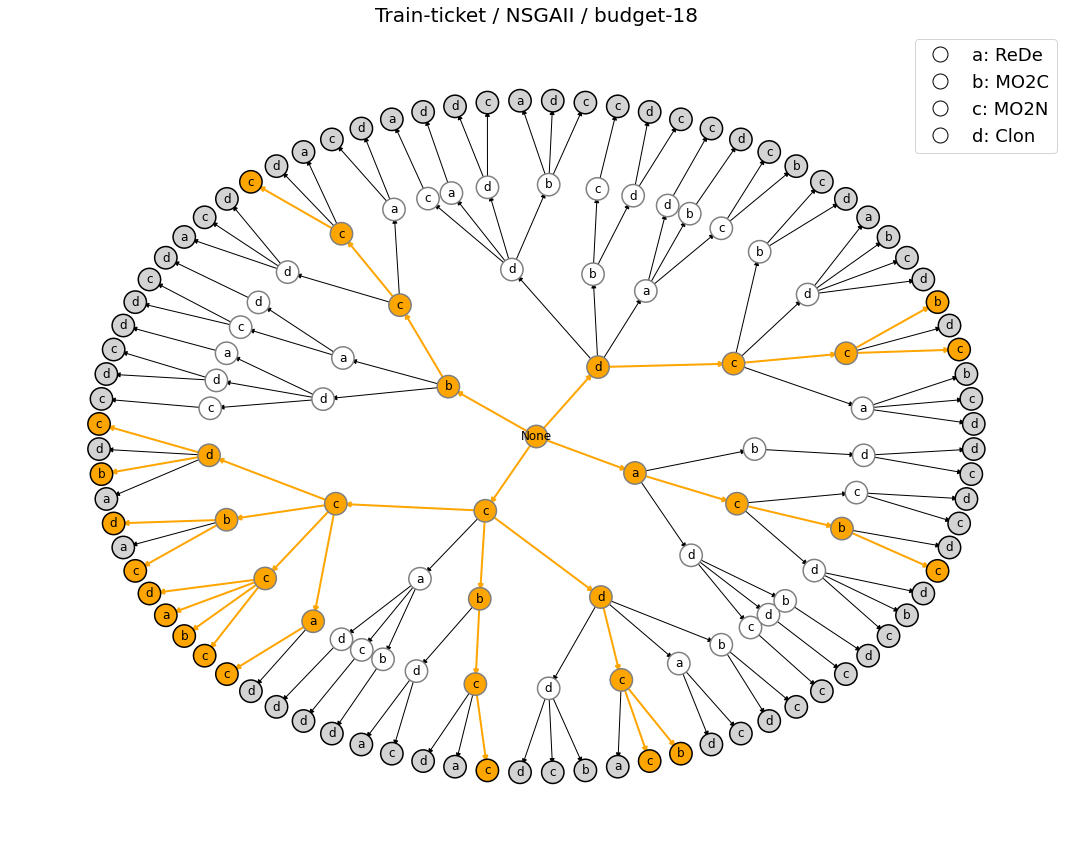

<ipython-input-10-d434091fb1e5>:68: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(trie, prog=prog, root='0')


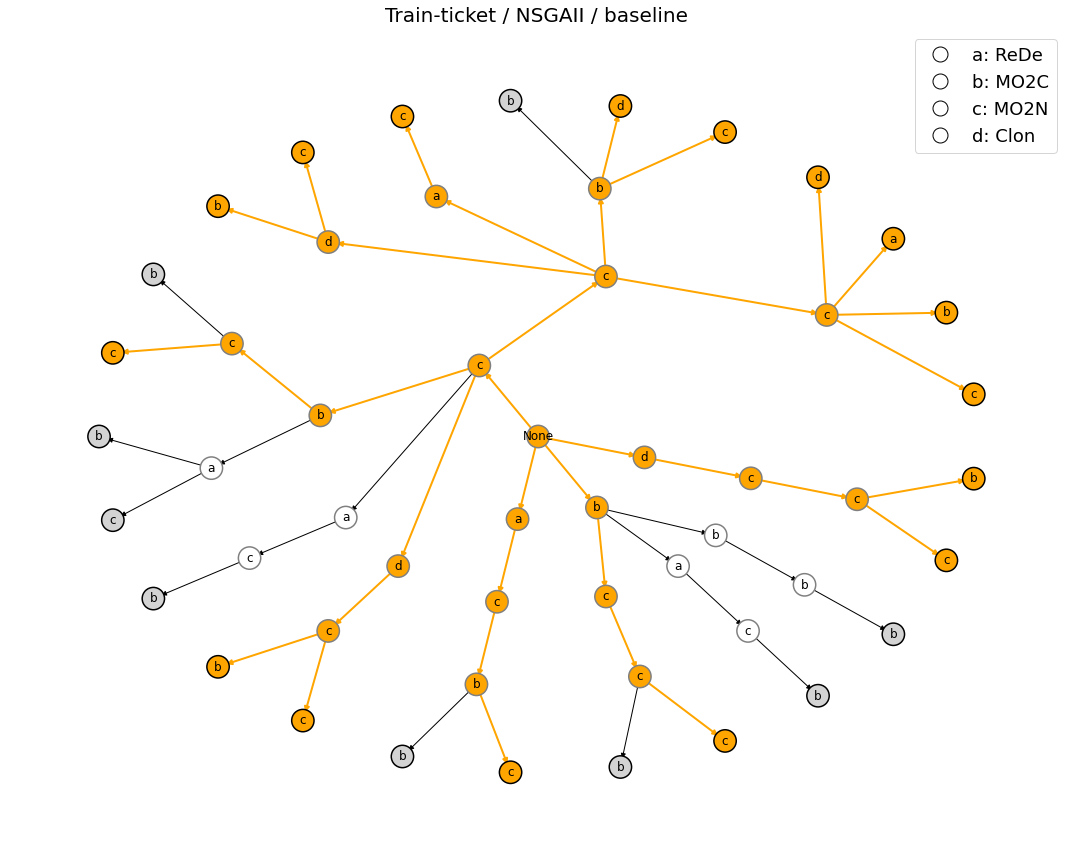

{'None': 'None',
 'd': 'UMLCloneNode',
 'c': 'Move_Operation_New_Component_New_Node',
 'a': 'Move_Component_New_Node',
 'b': 'Move_Operation_Component'}

In [14]:
# Code that loads 2 trees (in DOT format) and then compares them - TRAINTICKET
it18_trie = parse_trie('/content/files/datapfs/it18_trie_pf-trainticket-nsgaii.dot')
ref100_trie = parse_trie('/content/files/datapfs/ref100_trie_pf-trainticket-nsgaii.dot')

compare_tries(it18_trie, ref100_trie, title1='Train-ticket / NSGAII / budget-18', title2='Train-ticket / NSGAII / baseline')

84 sequences
25 sequences
Encoding: {'None': 'None', 'd': 'UMLCloneNode', 'c': 'Move_Operation_New_Component_New_Node', 'a': 'Move_Component_New_Node', 'b': 'Move_Operation_Component'}
intersection: 16 ['dccc', 'dccb', 'bccc', 'ccdc', 'ccdb', 'ccbd', 'ccbc', 'cccd', 'ccca', 'cccb', 'cccc', 'ccac', 'cbcc', 'cdcc', 'cdcb', 'acbc']


<ipython-input-10-d434091fb1e5>:68: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(trie, prog=prog, root='0')


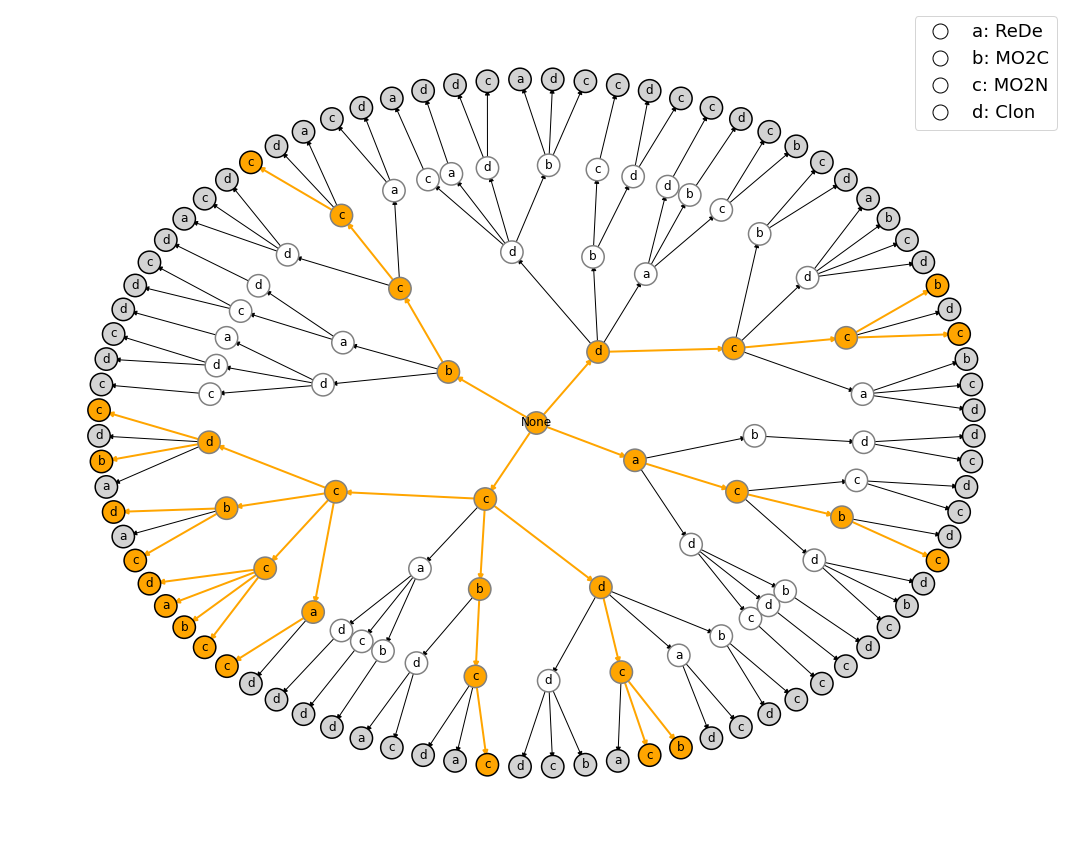

<ipython-input-10-d434091fb1e5>:68: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(trie, prog=prog, root='0')


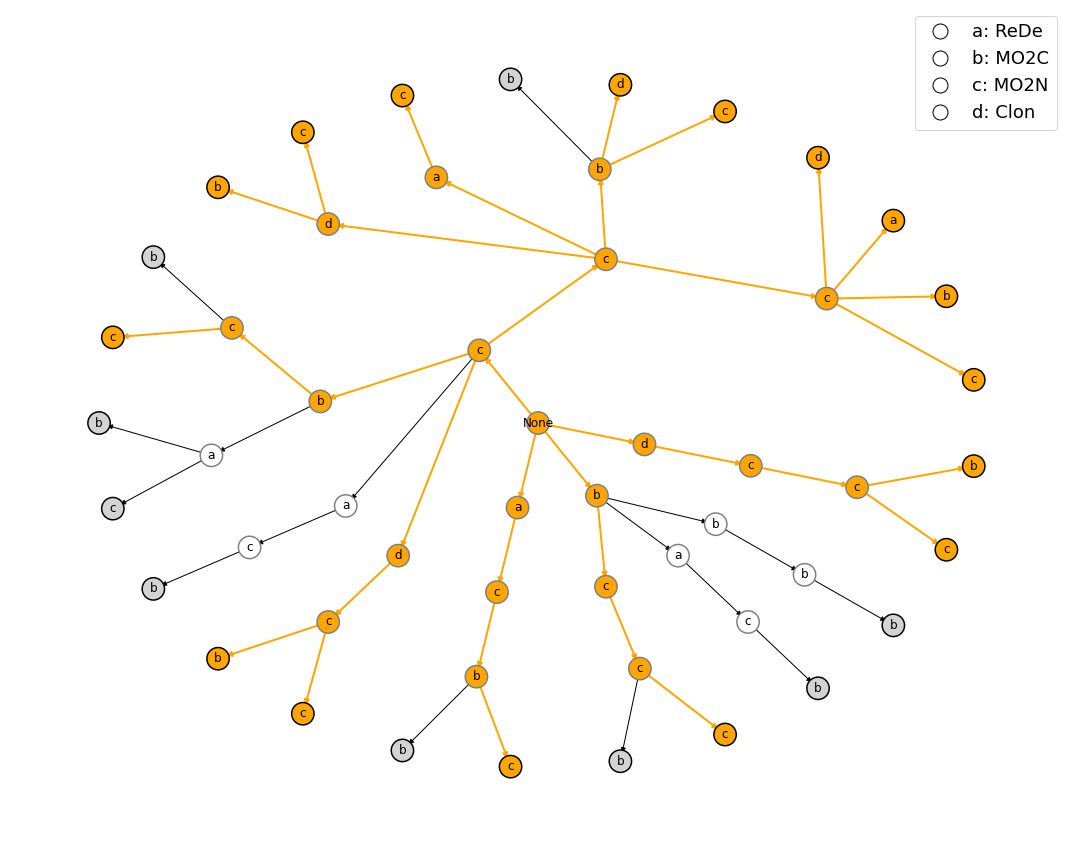

{'None': 'None',
 'd': 'UMLCloneNode',
 'c': 'Move_Operation_New_Component_New_Node',
 'a': 'Move_Component_New_Node',
 'b': 'Move_Operation_Component'}

In [15]:
compare_tries(it18_trie, ref100_trie) #, title1='CoCoMe / PESA2 / budget-18', title2='CoCoMe / PESA2 / baseline')

## **Scatter Plots for Objective Spaces (and Pareto fronts)**

In [16]:
# Function to load and create subfigures for the different combinations of objectives
def create_scatter_plot_subfigure(fig, budget, pf=True, objectives=['#changes', 'pas'], 
                                  left_title=True, title=True, algorithm=None, baseline=True,
                                  colors=['tab:red','tab:green', 'tab:blue'], 
                                  markers=['o','^', 's']):

  ttbs = dict() # Train-ticket
  ccm = dict() # Cocome
  ttbs_ref = dict()
  ccm_ref = dict()

  # TODO: This code should be refactored
  if pf: # Load only PF files 
    ttbs['nsgaii'] = pd.read_csv('/content/files/datapfs/ref_it'+str(budget)+'_pf-trainticket-nsgaii.csv')
    ttbs['spea2'] = pd.read_csv('/content/files/datapfs/ref_it'+str(budget)+'_pf-trainticket-spea2.csv')
    ttbs['pesa2'] = pd.read_csv('/content/files/datapfs/ref_it'+str(budget)+'_pf-trainticket-pesa2.csv')
    ccm['nsgaii'] = pd.read_csv('/content/files/datapfs/ref_it'+str(budget)+'_pf-cocome-nsgaii.csv')
    ccm['spea2'] = pd.read_csv('/content/files/datapfs/ref_it'+str(budget)+'_pf-cocome-spea2.csv')
    ccm['pesa2'] = pd.read_csv('/content/files/datapfs/ref_it'+str(budget)+'_pf-cocome-pesa2.csv')
  else:
    ttbs['nsgaii'] = pd.read_csv('/content/files/data/it'+str(budget)+'_space-trainticket-nsgaii.csv')
    ttbs['spea2'] = pd.read_csv('/content/files/data/it'+str(budget)+'_space-trainticket-spea2.csv')
    ttbs['pesa2'] = pd.read_csv('/content/files/data/it'+str(budget)+'_space-trainticket-pesa2.csv')
    ccm['nsgaii'] = pd.read_csv('/content/files/data/it'+str(budget)+'_space-cocome-nsgaii.csv')
    ccm['spea2'] = pd.read_csv('/content/files/data/it'+str(budget)+'_space-cocome-spea2.csv')
    ccm['pesa2'] = pd.read_csv('/content/files/data/it'+str(budget)+'_space-cocome-pesa2.csv')
  
  # TODO: This code should be refactored
  ttbs_ref['nsgaii'] = pd.read_csv('/content/files/datapfs/ref100_pf-trainticket-nsgaii.csv').sort_values(objectives, ascending=[True, False])
  ttbs_ref['spea2'] = pd.read_csv('/content/files/datapfs/ref100_pf-trainticket-spea2.csv').sort_values(objectives, ascending=[True, False])
  ttbs_ref['pesa2'] = pd.read_csv('/content/files/datapfs/ref100_pf-trainticket-pesa2.csv').sort_values(objectives, ascending=[True, False])
  ccm_ref['nsgaii'] = pd.read_csv('/content/files/datapfs/ref100_pf-cocome-nsgaii.csv').sort_values(objectives, ascending=[True, False])
  ccm_ref['spea2'] = pd.read_csv('/content/files/datapfs/ref100_pf-cocome-spea2.csv').sort_values(objectives, ascending=[True, False])
  ccm_ref['pesa2'] = pd.read_csv('/content/files/datapfs/ref100_pf-cocome-pesa2.csv').sort_values(objectives, ascending=[True, False])

  (ax1, ax2) = fig.subplots(2)
  # For Train-ticket
  for k, c, m in zip(ttbs.keys(),colors, markers):
    pf = ttbs[k][objectives].values
    baseline_pf = ttbs_ref[k][objectives].values
    if algorithm is None:
      #ax1.scatter(pf[:, 0], pf[:, 1], s=80, label=k, edgecolors=c, facecolor="none", linewidth=1, marker=m)
      if baseline:
        ax1.plot(baseline_pf[:, 0], baseline_pf[:, 1], label=k, color=c, linewidth=2, alpha=0.8)
      ax1.scatter(pf[:, 0], pf[:, 1], s=80, label=k, alpha=0.25, color=c, linewidth=1, marker=m)
    elif algorithm == k:
      if baseline:
        ax1.plot(baseline_pf[:, 0], baseline_pf[:, 1], label=k, color=c, linewidth=2, alpha=0.8)
      ax1.scatter(pf[:, 0], pf[:, 1], s=80, label=k, alpha=0.25, color=c, linewidth=1, marker=m)
      #ax1.scatter(baseline[:, 0], baseline[:, 1], s=80, label=k, edgecolors='black', facecolor='none', linewidth=1, marker=m)
    ax1.set_xlabel(objectives[0])
    ax1.set_ylabel(objectives[1])
    ax1.set_xlim(0,30)
    ax1.set_ylim(-0.5,6)
    if left_title:
      ax1.set_title('Train-ticket', rotation='vertical', x=-0.2,y=0.35, fontsize=16)
    else:
      ax1.set_title('Train-ticket', rotation='vertical', x=-0.2,y=0.35, fontsize=16, color='white')
  
  # For Cocome
  for k, c, m in zip(ccm.keys(),colors, markers):
    pf = ccm[k][objectives].values
    baseline_pf = ccm_ref[k][objectives].values
    if algorithm is None:
      #ax2.scatter(pf[:, 0], pf[:, 1], s=80, label=k, edgecolors=c, facecolor="none", linewidth=1, marker=m)
      if baseline:
        ax2.plot(baseline_pf[:, 0], baseline_pf[:, 1], label=k, color=c, linewidth=2, alpha=0.8)
      ax2.scatter(pf[:, 0], pf[:, 1], s=80, label=k, alpha=0.25, color=c, linewidth=1, marker=m)
    elif algorithm == k:   
      if baseline:
        ax2.plot(baseline_pf[:, 0], baseline_pf[:, 1], label=k, color=c, linewidth=2, alpha=0.8)   
      ax2.scatter(pf[:, 0], pf[:, 1], s=80, label=k, alpha=0.25, color=c, linewidth=1, marker=m)
      #ax2.scatter(pf[:, 0], pf[:, 1], s=80, label=k, edgecolors='black', facecolor='none', linewidth=1, marker=m)
      #ax2.plot(pf[:, 0], pf[:, 1], label=k, color=c, linewidth=2)
    ax2.set_xlabel(objectives[0])
    ax2.set_ylabel(objectives[1])
    ax2.set_xlim(0,30)
    ax2.set_ylim(-0.5,18)
    if left_title:
      ax2.set_title('CoCoMe', rotation='vertical', x=-0.2,y=0.35, fontsize=16)      
    else:
      ax1.set_title('CoCoMe', rotation='vertical', x=-0.2,y=0.35, fontsize=16, color='white')
  
  #plt.suptitle("Objective Space")
  labels = list(ttbs.keys())
  legend_elements = [ Line2D([0], [0], marker=markers[0], color='w', label=labels[0], markerfacecolor=colors[0], markersize=10), 
                     Line2D([0], [0], marker=markers[1], color='w', label=labels[1], markerfacecolor=colors[1], markersize=10),
                     Line2D([0], [0], marker=markers[2], color='w', label=labels[2], markerfacecolor=colors[2], markersize=10) ]
  #fig.figlegend(handles=legend_elements, ncol=3, loc='upper center')
  fig.legend(handles=legend_elements, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0.93), fontsize=11)
  if title:
    fig.suptitle("budget-"+str(budget))
  #fig.tight_layout(pad=3.0)
  #plt.show()

Show the 3 plots in the same figure (as sub-figures)

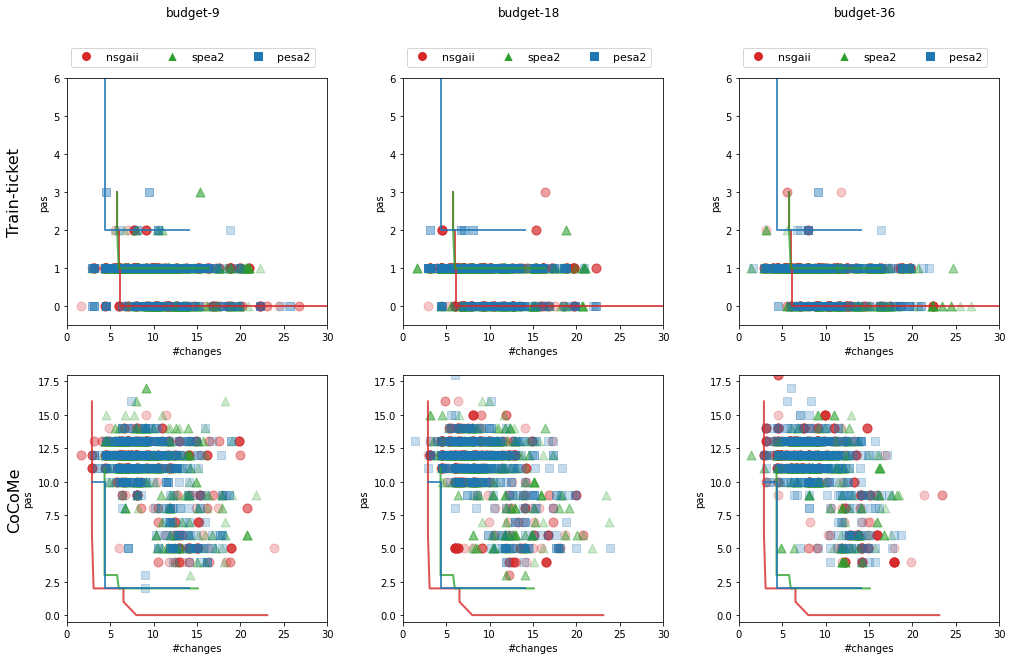

In [17]:
pfonly = False
algorithm = None #None #'spea2'
baseline = True
fig = plt.figure(figsize=(14, 10))
subfigs = fig.subfigures(1, 3, wspace=0.01)
create_scatter_plot_subfigure(subfigs[0], 9, pf=pfonly, left_title=True, algorithm=algorithm, baseline=baseline)
create_scatter_plot_subfigure(subfigs[1], 18, pf=pfonly, left_title=False, algorithm=algorithm, baseline=baseline)
create_scatter_plot_subfigure(subfigs[2], 36, pf=pfonly, left_title=False, algorithm=algorithm, baseline=baseline)

#fig.tight_layout(pad=3.0)
plt.show()

Show each plot individually (with some customization)

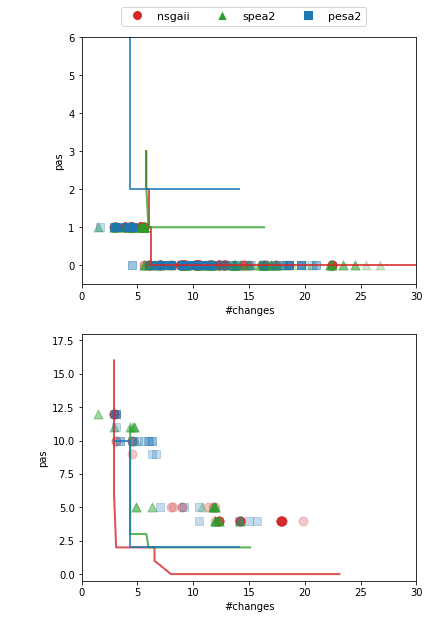

In [18]:
fig = plt.figure(figsize=(6, 10))
#create_scatter_plot_subfigure(fig, 9, pf=True, left_title=True, title=False, algorithm=None)
#create_scatter_plot_subfigure(fig, 18, pf=True, left_title=False, title=False, algorithm=None)
create_scatter_plot_subfigure(fig, 36, pf=True, left_title=False, title=False, algorithm=None)

#fig.tight_layout(pad=3.0)
plt.show()

## **Frequency Tables for Refactoring Actions**

In [19]:
refactions_names = {
    'Move_Component_New_Node': 'ReDe',
    'Move_Operation_Component': 'MO2C',
    'Move_Operation_New_Component_New_Node': 'MO2N',
    'UMLCloneNode': 'Clon'
}

Train-ticket

In [20]:
cols1 = [('nsgaii','15 min'),('nsgaii','30 min'),('nsgaii','60 min'),('nsgaii', 'baseline')]
cols2 = [('pesa2','15 min'),('pesa2','30 min'),('pesa2','60 min'),('pesa2', 'baseline')]
cols3 = [('spea2','15 min'),('spea2','30 min'),('spea2','60 min'),('spea2', 'baseline')]

# Read the corresponding files with the table information (and rename a few sub-columns)
barchart1_df = pd.read_csv('files/datapfs/nsgaii-refactions-trainticket.csv', header=[0, 1])
barchart1_df.rename(columns={'Unnamed: 0_level_1': '','Unnamed: 1_level_1': '', 'refactoring actions': 'ref. actions'}, inplace=True)

barchart2_df = pd.read_csv('files/datapfs/pesa2-refactions-trainticket.csv', header=[0, 1])[cols2]

barchart3_df = pd.read_csv('files/datapfs/spea2-refactions-trainticket.csv', header=[0, 1])[cols3]

all_df = pd.concat([barchart1_df, barchart2_df, barchart3_df], ignore_index=False, axis=1)
all_df[('pos','')] = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
all_df[('ref. actions', '')] = all_df[('ref. actions', '')].replace(refactions_names)
all_df

pos ref. actions    nsgaii                                   pesa2  \
                       15 min    30 min    60 min  baseline    15 min   
0    1         ReDe  0.165354  0.114370  0.091667  0.005195  0.073113   
1    1         MO2C  0.170604  0.164223  0.125000  0.062338  0.216981   
2    1         MO2N  0.380577  0.425220  0.444444  0.924675  0.384434   
3    1         Clon  0.283465  0.296188  0.338889  0.007792  0.325472   
4    2         ReDe  0.165354  0.079179  0.097222  0.005195  0.172170   
5    2         MO2C  0.188976  0.173021  0.197222  0.041558  0.125000   
6    2         MO2N  0.417323  0.434018  0.272222  0.948052  0.455189   
7    2         Clon  0.228346  0.313783  0.433333  0.005195  0.247642   
8    3         ReDe  0.167979  0.152493  0.147222  0.007792  0.132075   
9    3         MO2C  0.112861  0.155425  0.158333  0.044156  0.134434   
10   3         MO2N  0.406824  0.328446  0.322222  0.935065  0.450472   
11   3         Clon  0.312336  0.363636  0.372222  0.012987  0.283019   
12   4         ReDe  0.149606  0.079179  0.100000  0.002597  0.172170   
13   4         MO2C  0.141732  0.093842  0.052778  0.345455  0.115566   
14   4         MO2N  0.383202  0.475073  0.494444  0.644156  0.441038   
15   4         Clon  0.325459  0.351906  0.352778  0.007792  0.271226   

                                     spea2                                
      30 min    60 min  baseline    15 min    30 min    60 min  baseline  
0   0.108796  0.073394  0.207317  0.149068  0.208333  0.123570  0.051429  
1   0.136574  0.167431  0.085366  0.231884  0.208333  0.247140  0.025714  
2   0.402778  0.415138  0.658537  0.293996  0.300000  0.267735  0.842857  
3   0.351852  0.344037  0.048780  0.325052  0.283333  0.361556  0.080000  
4   0.083333  0.201835  0.170732  0.190476  0.150000  0.077803  0.082857  
5   0.155093  0.206422  0.121951  0.167702  0.169444  0.201373  0.042857  
6   0.506944  0.295872  0.658537  0.347826  0.425000  0.407323  0.765714  
7   0.254630  0.295872  0.048780  0.293996  0.255556  0.313501  0.108571  
8   0.129630  0.114679  0.195122  0.165631  0.105556  0.235698  0.057143  
9   0.099537  0.153670  0.073171  0.138716  0.100000  0.080092  0.040000  
10  0.469907  0.401376  0.719512  0.333333  0.427778  0.402746  0.842857  
11  0.300926  0.330275  0.012195  0.362319  0.366667  0.281465  0.060000  
12  0.097222  0.052752  0.109756  0.093168  0.086111  0.105263  0.085714  
13  0.148148  0.057339  0.268293  0.080745  0.050000  0.022883  0.037143  
14  0.476852  0.472477  0.609756  0.478261  0.494444  0.386728  0.808571  
15  0.277778  0.417431  0.012195  0.347826  0.369444  0.485126  0.068571

In [21]:
# Conversion of the tables to formatted dataframes - TRAINTICKET
cmap = sns.color_palette('viridis_r', as_cmap=True)

trainticket_styled_df = all_df.style.background_gradient(cmap=cmap, subset=cols1+cols2+cols3, vmin=0.0, vmax=1.0).format(precision=2).hide_index()
trainticket_styled_df

<ipython-input-21-c56c5390628c>:4: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  trainticket_styled_df = all_df.style.background_gradient(cmap=cmap, subset=cols1+cols2+cols3, vmin=0.0, vmax=1.0).format(precision=2).hide_index()


<ipython-input-22-8e5094272b78>:2: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = trainticket_styled_df.render()


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


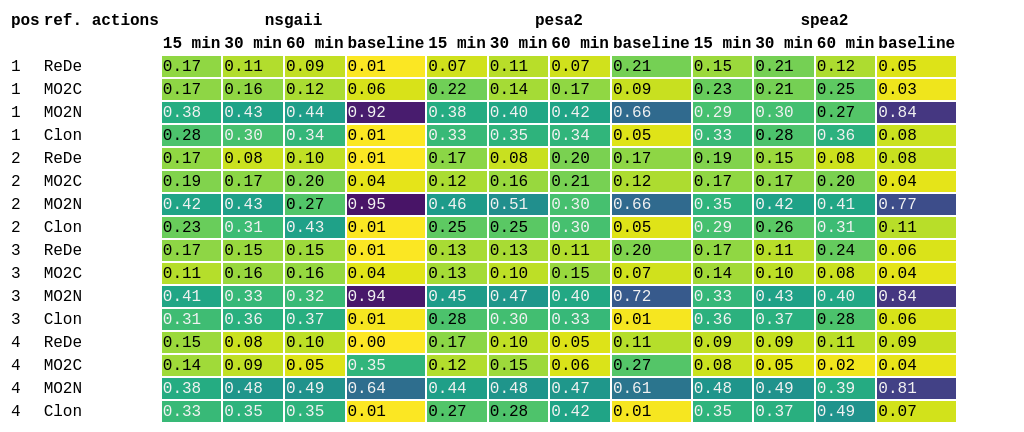

In [22]:
# Conversion of the styled dataframe to an image
html = trainticket_styled_df.render()
imgkit.from_string(html, 'styled_table.png')
Image.open('styled_table.png')

CoCoME

In [23]:
# Read the corresponding files with the table information (and rename a few sub-columns)
barchart1_df = pd.read_csv('files/datapfs/nsgaii-refactions-cocome.csv', header=[0, 1])
barchart1_df.rename(columns={'Unnamed: 0_level_1': '','Unnamed: 1_level_1': ''}, inplace=True)
barchart1_df.rename(columns={'Unnamed: 0_level_1': '','Unnamed: 1_level_1': '', 'refactoring actions': 'ref. actions'}, inplace=True)
#barchart1_df = barchart1_df[[('pos','')]+cols1]

barchart2_df = pd.read_csv('files/datapfs/pesa2-refactions-cocome.csv', header=[0, 1])[cols2]

barchart3_df = pd.read_csv('files/datapfs/spea2-refactions-cocome.csv', header=[0, 1])[cols3]

all_df = pd.concat([barchart1_df, barchart2_df, barchart3_df], ignore_index=False, axis=1)
all_df[('pos','')] = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
all_df[('ref. actions', '')] = all_df[('ref. actions', '')].replace(refactions_names)
all_df

pos ref. actions    nsgaii                                  pesa2  \
                       15 min    30 min    60 min  baseline   15 min   
0    1         ReDe  0.164251  0.217742  0.147887  0.203125  0.15625   
1    1         MO2C  0.212560  0.217742  0.239437  0.109375  0.21875   
2    1         MO2N  0.333333  0.276210  0.246479  0.640625  0.28125   
3    1         Clon  0.289855  0.288306  0.366197  0.046875  0.34375   
4    2         ReDe  0.188406  0.185484  0.169014  0.140625  0.16875   
5    2         MO2C  0.202899  0.209677  0.288732  0.234375  0.21250   
6    2         MO2N  0.347826  0.377016  0.232394  0.593750  0.27500   
7    2         Clon  0.260870  0.227823  0.309859  0.031250  0.34375   
8    3         ReDe  0.135266  0.090726  0.077465  0.234375  0.16875   
9    3         MO2C  0.140097  0.149194  0.112676  0.156250  0.08750   
10   3         MO2N  0.391304  0.395161  0.352113  0.593750  0.40000   
11   3         Clon  0.333333  0.364919  0.457746  0.015625  0.34375   
12   4         ReDe  0.048309  0.072581  0.176056  0.171875  0.12500   
13   4         MO2C  0.115942  0.125000  0.056338  0.609375  0.11250   
14   4         MO2N  0.415459  0.405242  0.415493  0.218750  0.38125   
15   4         Clon  0.420290  0.397177  0.352113  0.000000  0.38125   

                                     spea2                               
      30 min    60 min  baseline    15 min    30 min    60 min baseline  
0   0.132075  0.149123  0.207317  0.208661  0.199115  0.141975     0.28  
1   0.194969  0.210526  0.085366  0.240157  0.230088  0.191358     0.04  
2   0.308176  0.271930  0.658537  0.275591  0.221239  0.302469     0.64  
3   0.364780  0.368421  0.048780  0.275591  0.349558  0.364198     0.04  
4   0.182390  0.131579  0.170732  0.212598  0.194690  0.123457     0.12  
5   0.176101  0.201754  0.121951  0.153543  0.185841  0.191358     0.04  
6   0.358491  0.315789  0.658537  0.303150  0.252212  0.419753     0.80  
7   0.283019  0.350877  0.048780  0.330709  0.367257  0.265432     0.04  
8   0.144654  0.166667  0.195122  0.133858  0.163717  0.179012     0.12  
9   0.138365  0.131579  0.073171  0.208661  0.168142  0.086420     0.04  
10  0.364780  0.377193  0.719512  0.326772  0.323009  0.438272     0.84  
11  0.352201  0.324561  0.012195  0.330709  0.345133  0.296296     0.00  
12  0.144654  0.070175  0.109756  0.082677  0.084071  0.148148     0.08  
13  0.081761  0.114035  0.268293  0.102362  0.097345  0.049383     0.24  
14  0.415094  0.464912  0.609756  0.429134  0.376106  0.413580     0.60  
15  0.358491  0.350877  0.012195  0.385827  0.442478  0.388889     0.08

In [24]:
# Conversion of the tables to formatted dataframes - COCOME
cocome_styled_df = all_df.style.background_gradient(cmap=cmap, subset=cols1+cols2+cols3, vmin=0.0, vmax=1.0).format(precision=2).hide_index()
cocome_styled_df

<ipython-input-24-46376167aebd>:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  cocome_styled_df = all_df.style.background_gradient(cmap=cmap, subset=cols1+cols2+cols3, vmin=0.0, vmax=1.0).format(precision=2).hide_index()


<ipython-input-25-3bb1d7f1baa8>:2: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = cocome_styled_df.render()


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


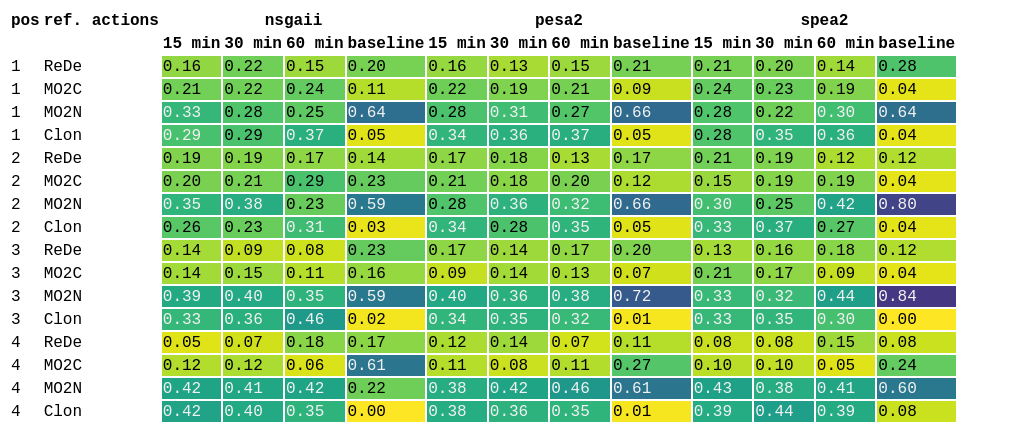

In [25]:
# Conversion of the styled dataframe to an image
html = cocome_styled_df.render()
imgkit.from_string(html, 'styled_table.png')
Image.open('styled_table.png')

---
## **Another Visualization of Pareto fronts**

In [26]:
from os.path import basename
from glob import glob
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

class Pareto:

    def __init__(self, file):
        self.file = file
        self.parse_filename()
        self.read_rf()

    def parse_filename(self):
        m = re.match(r'(?P<algo>[^-]+)-(?P<usecase>.+)-bytime-(?P<time>\d+).rf',
                basename(self.file))
        if m is not None:
            for k, v in m.groupdict().items():
                setattr(self, k, v)
        self.algo = self.algo.upper()

    def read_rf(self):
        df = pd.read_csv(self.file, header=0,
                names=['perfQ', '#changes', 'pas', 'reliability'])
        self.df = Pareto.fix_perfq_rel(df)
        return self.df

    @staticmethod
    def fix_perfq_rel(df):
        if 'perfQ' in df:
            df['perfQ'] = df['perfQ'] * -1
        if 'reliability' in df:
            df['reliability'] = df['reliability'] * -1
        return df

In [27]:
from matplotlib.ticker import FormatStrFormatter

def get_initial(reliability):
    return pd.DataFrame([[0, reliability, 0, 0]],
                        columns=['perfQ', 'reliability', '#changes', 'pas'])

def sol_scatter(ax, df, marker, markersize, color, label=''):
    #return ax.scatter(df['#changes'], df['pas'],
    return ax.scatter(df['perfQ'], df['reliability'],
            s=200, #s=df['#changes']*markersize, 
            marker=marker, label=label,
            alpha=0.5, c=color)

def labels(ax, artists, hue):
    ax.set_xlabel('PerfQ', fontsize=22)
    ax.set_ylabel('Reliability', fontsize=22)
    #ax.set_xlabel('#Changes', fontsize=22)
    #ax.set_ylabel('Pas', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #lgnd = plt.legend(loc='lower right', handletextpad=-0.3, fontsize=16)
    fake = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    lgnd = ax.legend([fake] + artists,
            [hue] + [a.get_label() for a in artists],
            loc='upper center', handletextpad=-0.3, fontsize=18,
            fancybox=True, shadow=False, ncol=len(artists)+1, bbox_to_anchor=(0.5, 1.1))
    for handle in lgnd.legendHandles[1:]:
        handle.set_sizes([50])

def plot_initial(ax, sol):
    ax.scatter(sol['perfQ'], sol['reliability'], s=75, marker='X', alpha=1, c='black')
    #ax.scatter(sol['#changes'], sol['pas'], s=75, marker='X', alpha=1, c='black')
    ax.annotate("initial", fontsize=14, xy=(sol['perfQ'], sol['reliability']), xycoords='data',
    #ax.annotate("initial", fontsize=14, xy=(sol['#changes'], sol['pas']), xycoords='data',
                xytext=(25, -25), textcoords='offset points', ha="left", va="center",
                arrowprops=dict(arrowstyle="wedge,tail_width=.01", facecolor='black'))

def plot_pareto(experiments, hue, cs, initial=None, save_prefix=None,
        colors=[1, 0, 2, 3], 
        markers=['s', 'o', '^', 'D', 'p'],
        legend_title=None):
    experiments.sort(key=lambda x: getattr(x, hue))

    fig, ax = plt.subplots(figsize=[10, 8])

    # Plot
    artists = []
    for i, exp in enumerate(experiments):
        #ax.set_ylim([0, 1])
        #ax.set_xlim([-0.07, 0.27])
        if cs == 'simplified-cocome':
          ax.set_ylim([-0.1, 1.0]) # For Cocome
          ax.set_xlim([-0.15, 0.45]) # For Cocome
          #ax.set_ylim([0, 20]) # For Cocome
          #ax.set_xlim([0, 25]) # For Cocome
        else:
          ax.set_ylim([-0.1, 1.0]) # For Train-ticket
          ax.set_xlim([-0.15, 0.45]) # For Train-ticket
          #ax.set_ylim([-0.1, 1.5]) # For Train-ticket
          #ax.set_xlim([0, 25]) # For Train-ticket
        artists.append(sol_scatter(ax, exp.df, markers[i], 50,
            color=[plt.cm.tab10(colors[i])], label=getattr(exp, hue)))

    # Initial solution
    if initial is not None:
        plot_initial(ax, initial)

    # Labels
    if legend_title is None:
        legend_title = hue
    labels(ax, artists, legend_title)

    # Grid
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')

    plt.tight_layout()
    if cs.startswith('simplified'):
      cs = 'CoCoME'
    else:
      cs = 'TTBS'
    #ax.set_title(cs, color='white', rotation='vertical', x=-0.2, y=0.4, weight='bold')
    #ax.title.set_size(24)

    filename = '{}_2dscatter.pdf'.format(save_prefix) #'{}_2dscatter.pdf'.format(save_prefix)
    plt.savefig(filename)
    print('Saved to: {}'.format(filename))
    return filename

In [28]:
!mkdir '/content/files/rfs/figs' 

1800000 simplified-cocome


<ipython-input-27-1953789e897b>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles[1:]:


Saved to: /content/files/rfs/figs/simplified-cocome_1800000_2dscatter.pdf
1800000 train-ticket


<ipython-input-27-1953789e897b>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles[1:]:


Saved to: /content/files/rfs/figs/train-ticket_1800000_2dscatter.pdf
3600000 simplified-cocome


<ipython-input-27-1953789e897b>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles[1:]:


Saved to: /content/files/rfs/figs/simplified-cocome_3600000_2dscatter.pdf
3600000 train-ticket


<ipython-input-27-1953789e897b>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles[1:]:


Saved to: /content/files/rfs/figs/train-ticket_3600000_2dscatter.pdf
900000 simplified-cocome


<ipython-input-27-1953789e897b>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles[1:]:


Saved to: /content/files/rfs/figs/simplified-cocome_900000_2dscatter.pdf
900000 train-ticket


<ipython-input-27-1953789e897b>:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles[1:]:


Saved to: /content/files/rfs/figs/train-ticket_900000_2dscatter.pdf


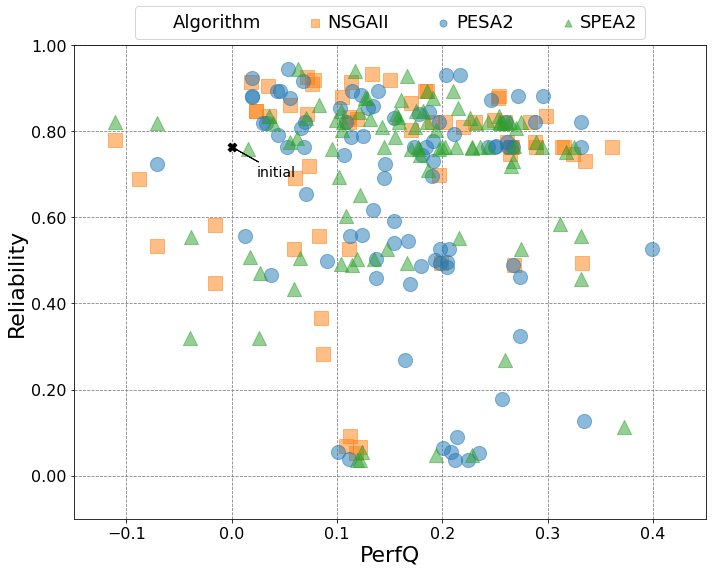

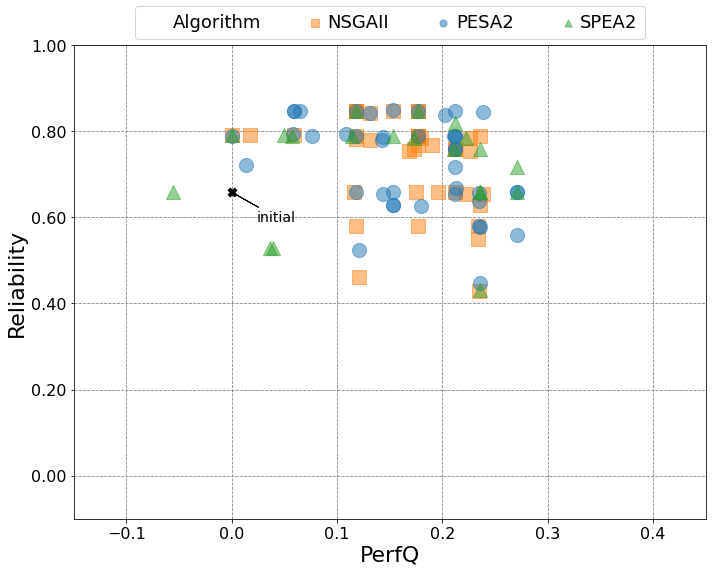

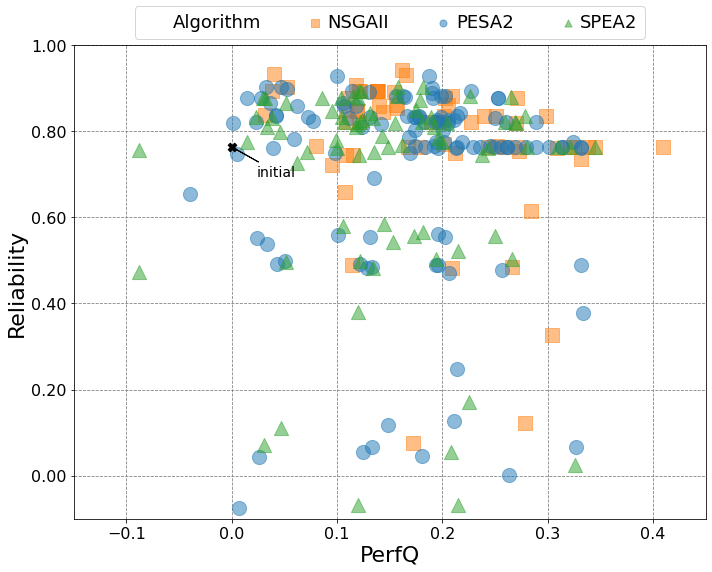

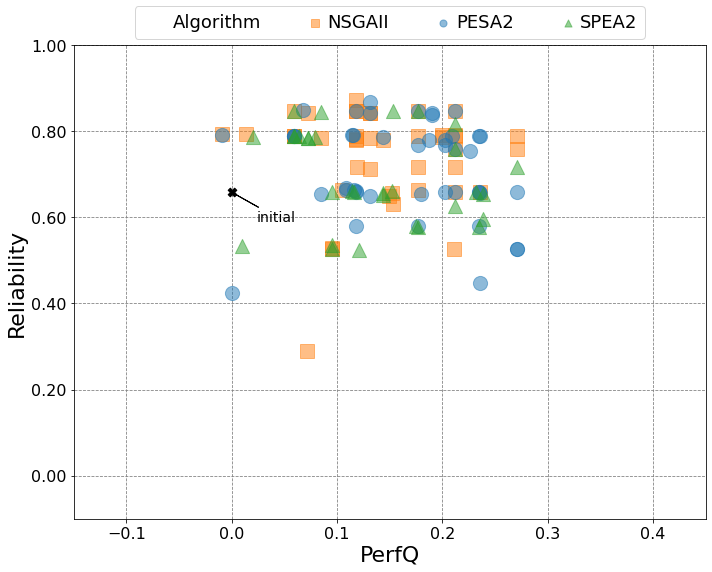

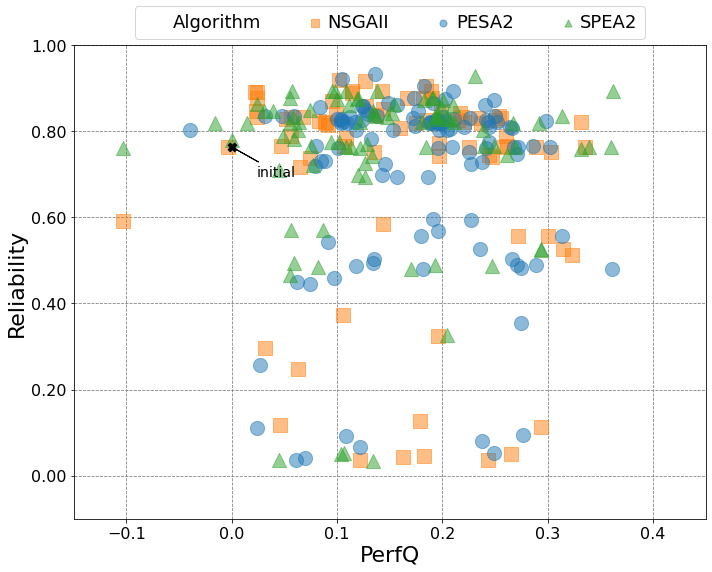

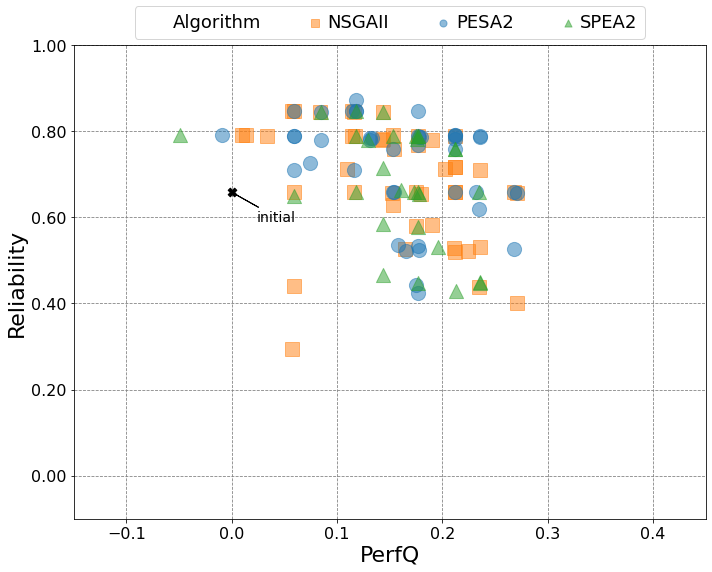

In [29]:
DATA_DIR = '/content/files/rfs' 
FIGS = DATA_DIR+'/figs/'

initials = {
    'ttbs':   get_initial(0.657925),
    'cocome': get_initial(0.7630625563279512),
}
initials['train-ticket'] = initials['ttbs']
initials['simplified-cocome'] = initials['cocome']

experiments = [Pareto(f) for f in glob(DATA_DIR + '/*-bytime-[0-9]*.rf')]

for time in set([p.time for p in experiments]):
    for cs in set([p.usecase for p in experiments]):
        print(time,cs)
        exp = [p for p in experiments if p.usecase == cs and p.time == time]
        plot_pareto(exp, 'algo', cs, initial=initials[cs], save_prefix='{}{}_{}'.format(FIGS, cs, time), legend_title='Algorithm')

In [30]:
list_figures = []
for time in set([p.time for p in experiments]):
    for cs in set([p.usecase for p in experiments]):
      txt = '{}{}_{}'.format(FIGS, cs, time)+'_2dscatter.png'
      list_figures.append(txt)
list_figures

['/content/files/rfs/figs/simplified-cocome_1800000_2dscatter.png',
 '/content/files/rfs/figs/train-ticket_1800000_2dscatter.png',
 '/content/files/rfs/figs/simplified-cocome_3600000_2dscatter.png',
 '/content/files/rfs/figs/train-ticket_3600000_2dscatter.png',
 '/content/files/rfs/figs/simplified-cocome_900000_2dscatter.png',
 '/content/files/rfs/figs/train-ticket_900000_2dscatter.png']

---